In [40]:
import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import os
from matplotlib import gridspec
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy import interpolate, integrate
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter") ## add this folder to the environment 
from entities_v2 import GCaMPData ,LimbData, Frame, Clip, Experiment

# # Interactive plots in Jupyter lab 
# %matplotlib widget  
# plt.close('all')


In [41]:
filename = 'M564_eEPA_Habenula'  # The same filename you used when saving
data_folder = r'Z:\UriMons\Fiber Photometry\GCaMP\Habenula\Processed_Data\Pickles'
pkl=os.path.join(data_folder, filename)
# Load the object from the pickle file
with open(f'{pkl}.pkl', 'rb') as f:
    loaded_object : Experiment = pickle.load(f)

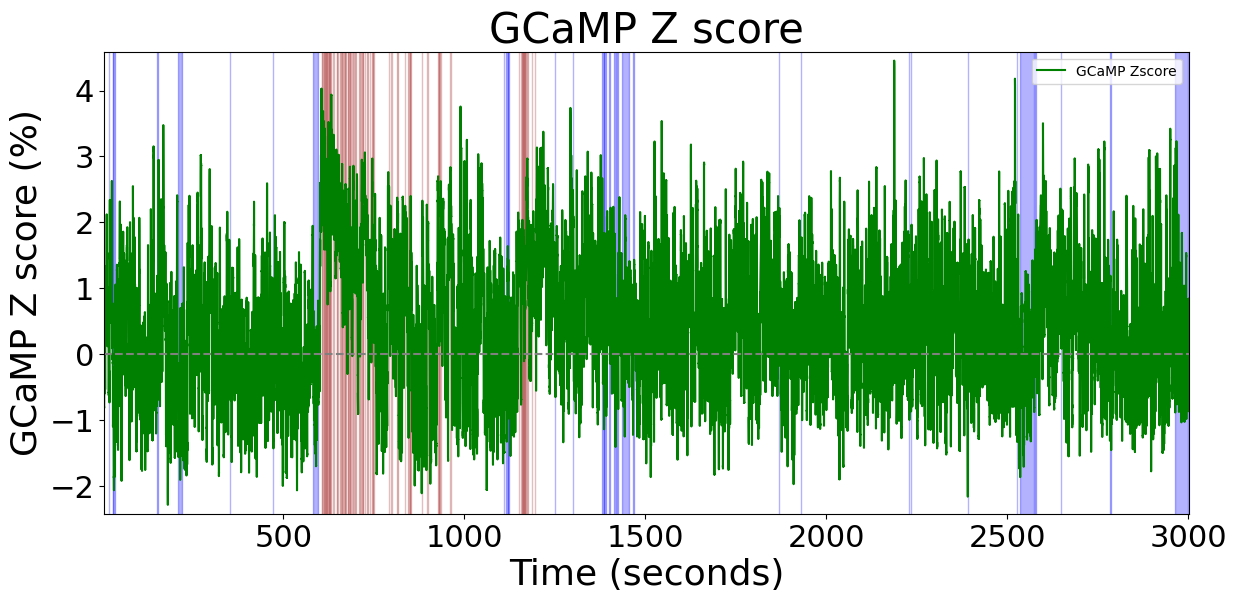

('M564', 'Sapap(WT); CRH(Hetro)', 'F', 'eEPA')

In [42]:
#loaded_object.plot_gcamp_with_annotations()
loaded_object.plot_gcamp_zscore_with_annotations()
ID = loaded_object.Mouse_id
Gen = loaded_object.Genotype
Para = loaded_object.paradigm
Sex = loaded_object.Sex
ID, Gen, Sex, Para

In [43]:
#Zoom in (seconds)
#loaded_object.plot_gcamp_zscore_with_annotations(None,60, 69, -3, 8)

In [44]:
gcamp_z_score, time_seconds = loaded_object.get_gcamp_data_Z_score(start_frame = 0, end_frame = 150000)
filterdata = gcamp_z_score

GCaMP data (z-score) example: [-0.8021 -0.8127 -0.7772 ... -0.0119 -0.2587 -0.5518]
The length of the array is: 149878


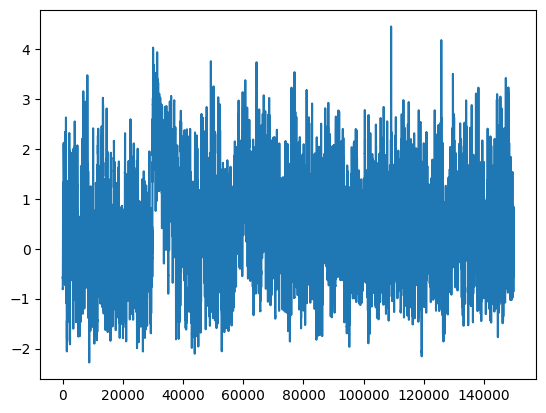

In [45]:
print(f"GCaMP data (z-score) example: {gcamp_z_score}")
print(f"The length of the array is: {len(filterdata)}")
plt.plot(filterdata)

In [46]:
# Define the signal variable: current or voltage (raw or processed)
peaks_signal = -filterdata  # trace after pre-processing 
individual_list = [] 
# You could also select a range of the trace with the below option
# peaks_signal = current_filtered[5000:50000]
fs = 50  # Sampling frequency
# Event window parameters
event_no = 30  # Event viewer: 0 is the first event
pretrigger_window = (0.3 * fs)  # Pre-event time window in ms
posttrigger_window = (1.5 * fs)  # Post-event time window in ms

# Set parameters of the Find peaks function
thresh_min = 1
thresh_max = 10
thresh_prominence = 2 # This is the change from the dynamic baseline
thresh_min_width = 10 * (fs/1000) # 
 
# Find peaks function
peaks, peaks_dict = find_peaks(-peaks_signal, 
           height=(thresh_min, thresh_max),  # Min and max thresholds to detect peaks.
           threshold=None,  # Min and max vertical distance to neighboring samples.
           distance=None,  # Min horizontal distance between peaks.
           prominence=thresh_prominence,  # Vertical distance between the peak and lowest contour line.
           width=thresh_min_width,  # Min required width (in bins). E.g. For 10Khz, 10 bins = 1 ms.
           wlen=None,  # Window length to calculate prominence.
           rel_height=0.5,  # Relative height at which the peak width is measured.
           plateau_size=None)
  
# Create table with results
table = pd.DataFrame(columns = ['event', 'peak_index', 
                                'peak_time_s',
                                'event_window_start', 'event_window_end',
                                'peak_amp', 'width_ms', 
                                'inst_freq', 'isi_s', 
                                'area', 'decay_tau_log', 
                                'decay_tau_exp', 'rise_tau_exp'])
  
table.event = np.arange(1, len(peaks) + 1)
table.peak_index = peaks
table.peak_time_s = peaks / fs  # Divided by fs to get s
table.event_window_start = peaks_dict['left_ips'] - pretrigger_window
table.event_window_end = peaks_dict['right_ips'] + posttrigger_window
table.peak_amp = peaks_dict['peak_heights']  # height parameter is needed
table.width_ms = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
 
# Additional parameters (remember to add the columns to the dataframe)
# table.rise_half_amp_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
# table.decay_half_amp_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
  
# Calculations based on the parameters above
table.inst_freq = np.insert((1 / (np.array(table.peak_index[1:]) -
                                  np.array(table.peak_index[:-1])) * fs), 
                            0, np.nan) 
 
table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
 
for i, event in table.iterrows():
     
    # Event area as absolute value (abs)
    individual_event = peaks_signal[int(event.event_window_start) : int(event.event_window_end)]
    individual_list.append(individual_event)
    table.loc[i, 'area'] = abs(round(individual_event.sum()/(fs/1000), 2))  # pA x ms
     
    # Decay tau from logistic regression
    decay_tau = abs(peaks_signal[int(event.peak_index) : int(event.event_window_end)])
    decay_tau_log = np.log(decay_tau)
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))
    slope, _ = np.polyfit(decay_width_array, decay_tau_log, 1)
    tau = -1 / slope
    table.loc[i, 'decay_tau_log'] = tau/(fs/1000) 
 
    # Decay tau from monoexponential fitting
    decay_tau = peaks_signal[int(event.peak_index) : int(event.event_window_end)]
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))
    a_initial = 200
    b_initial = 0.1
    
    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                           decay_width_array, decay_tau, 
                           p0=(a_initial, b_initial), 
                           maxfev=10000)  # maxfev: number of iterations
    a = popt[0]  
    b = popt[1]      
    table.loc[i, 'decay_tau_exp'] = abs((1/b)/(fs/1000))
     
    # Rise tau from monoexponential fitting
    rise_tau = peaks_signal[int(event.event_window_start):int(event.peak_index)]
    rise_width = int(len(rise_tau))
    rise_width_array = list(range(0, rise_width))
    a_initial = 200
    b_initial = 0.1

    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                           rise_width_array, rise_tau, 
                           p0=(a_initial, b_initial), 
                           maxfev=10000)  # maxfev: number of iterations
    a = popt[0]  
    b = popt[1]      
    table.loc[i, 'rise_tau_exp'] = abs((1/b)/(fs/1000))

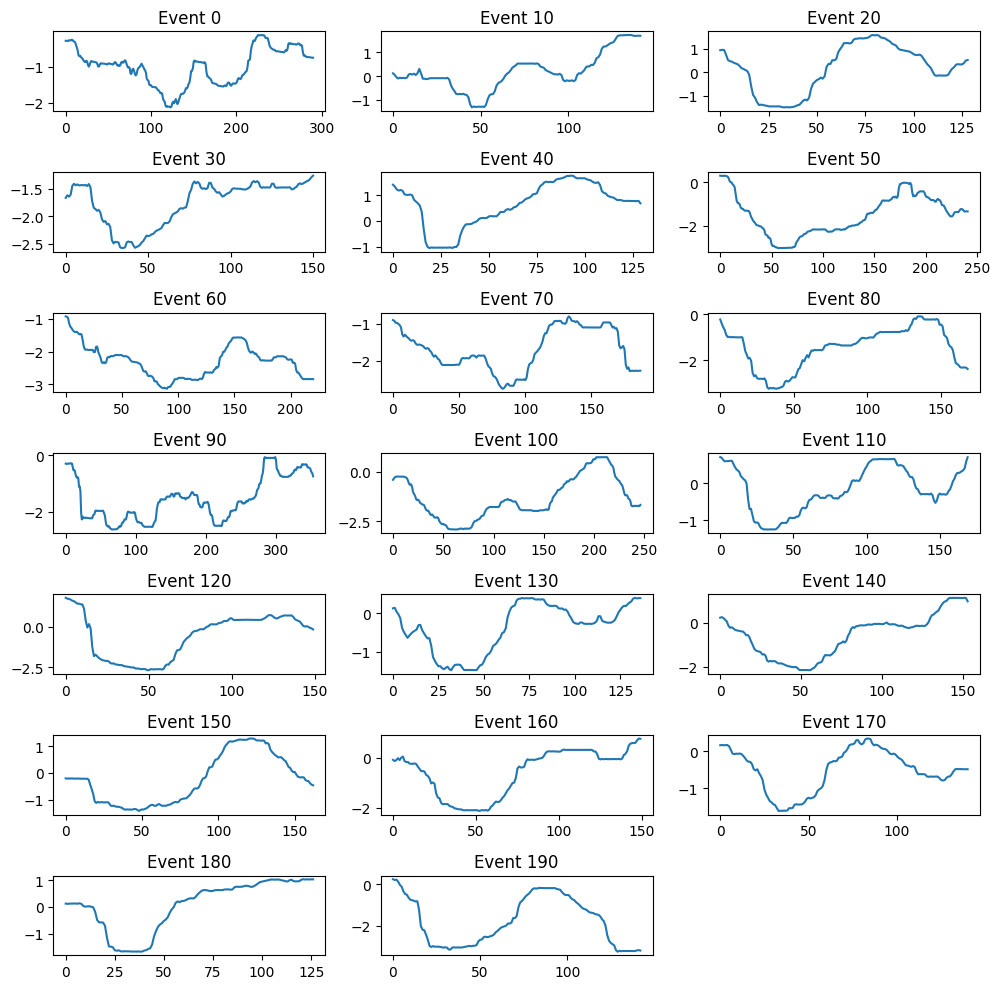

In [47]:
# Select every 10th event
selected_events = individual_list[::20]

# Number of subplots (rows x cols)
num_plots = len(selected_events)
cols = 3  # You can adjust the number of columns
rows = -(-num_plots // cols)  # This is the same as math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of multiple rows

# Plot each selected event in a subplot
for i, ploty in enumerate(selected_events):
    axes[i].plot(ploty)
    axes[i].set_title(f"Event {i * 10}")  # Show original index

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove extra empty plots

plt.tight_layout()
plt.show()


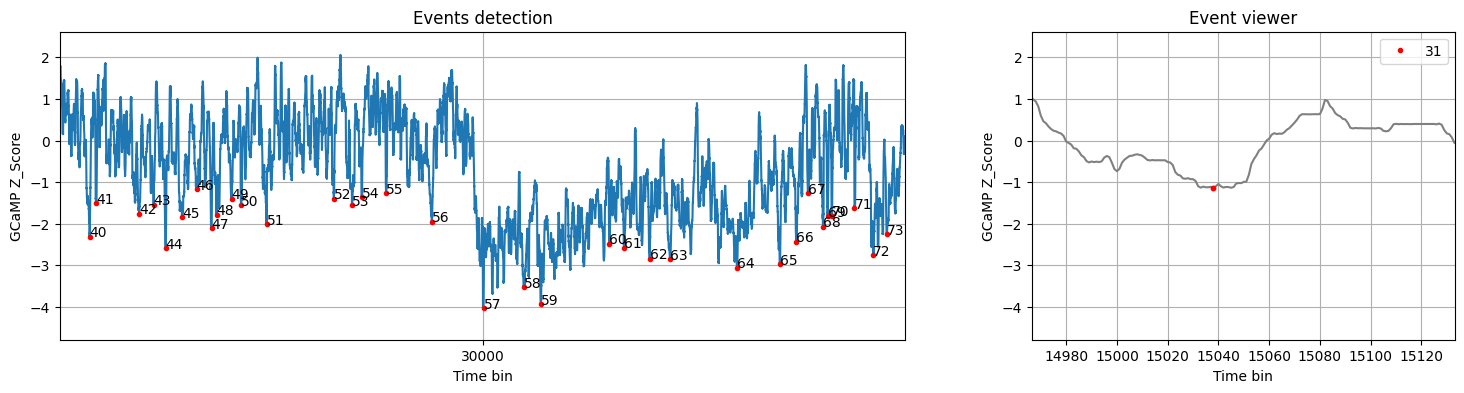

,event,peak_index,peak_time_s,event_window_start,event_window_end,peak_amp,width_ms,inst_freq,isi_s,area,decay_tau_log,decay_tau_exp,rise_tau_exp
0,1,353,7.06,230.541,521.435,2.123,4017.879,NaN,0.00,5832.07,2007.782329,2162.340355,1749.204797
1,2,1065,21.30,895.306,1166.576,2.630,3625.397,0.070,14.24,7235.34,1424.339759,595.191345,4043.031072
2,3,1560,31.20,1528.066,1653.731,1.059,713.290,0.101,9.90,334.89,-2255.76917,664.168198,161.139975
3,4,1768,35.36,1671.674,1875.294,1.360,2272.388,0.240,4.16,398.41,-6500.736651,861.646848,788.024441
4,5,2169,43.38,2050.690,2410.838,2.319,5402.949,0.125,8.02,5659.36,5561.913332,540.579725,1329.199129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,382,148116,2962.32,148081.462,148229.104,3.232,1152.842,0.515,1.94,2786.37,804.961124,335.370196,322.244029
382,383,148383,2967.66,148308.858,148478.606,2.118,1594.970,0.187,5.34,2078.56,1670.708717,279.036184,959.38124
383,384,148613,2972.26,148558.802,148714.414,1.392,1312.245,0.217,4.60,843.08,518.46956,593.913909,528.038664
384,385,148867,2977.34,148836.524,148980.697,1.842,1083.450,0.197,5.08,1173.67,535.206337,418.711609,171.606514


In [48]:
# Plotting
fig = plt.figure(figsize=(18,4))
gridspec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
 
# Plot 1: Detected events in the trace
ax1 = fig.add_subplot(gridspec[0])  # gridspec specifies the ratio between plots
ax1.set_title("Events detection")   
ax1.plot(peaks_signal)
ax1.plot(peaks, peaks_signal[peaks], "r.")
ax1.grid(True) 
ax1.set_xticks(np.arange(0, ax1.get_xlim()[1], 30000))  # Set x-axis ticks
for i, txt in enumerate(table.event):
    ax1.annotate(table.event[i], (peaks[i], peaks_signal[peaks][i]))
ax1.set_xlabel("Time bin")
ax1.set_ylabel("GCaMP Z_Score")
ax1.axes.set_xlim(20000, 40000)  # OptionaL: Zoom in the trace
  
# Plot 2: Event viewer
ax2 = fig.add_subplot(gridspec[1]) 
ax2.set_title("Event viewer")
ax2.plot(peaks_signal, "gray")
ax2.plot(peaks, peaks_signal[peaks], "r.")
ax2.grid(True)
ax2.set_xlabel("Time bin")
ax2.set_ylabel("GCaMP Z_Score")
# Event time window
ax2.set_xlim(table.event_window_start[event_no], table.event_window_end[event_no]) 
# Labeling the event
line, = ax2.plot(peaks, peaks_signal[peaks], "r.") 
line.set_label(table.event[event_no]) 
ax2.legend()
        
# Show graph and table
plt.show()
table.round(3)  # round: display of decimal numbers in the table

In [49]:
# Assuming `table` contains your data with peaks and amplitudes
peaks = table.peak_index  # Detected peaks
peak_amplitudes = table.peak_amp  # Corresponding peak amplitudes
signal_length = len(peaks_signal)  # Total length of the signal

# Define bin size and number of bins
single_minute = 60 * fs
small_bin_size = 5 * single_minute # 5 minute bins
large_bin_size = 10 * single_minute # 10 minute bins 
bin_size = int(single_minute) 
num_bins = (signal_length // bin_size) + (1 if signal_length % bin_size != 0 else 0)

# Initialize a dictionary to store results
peak_stats = {
    "bin_start": [],
    "bin_end": [],
    "peak_count": [],
    "avg_amplitude": [],
    "std_amplitude": [],
    "sem_amplitude": []
}

# Calculate statistics for each bin
for i in range(num_bins):
    bin_start = i * bin_size
    bin_end = min((i + 1) * bin_size, signal_length)

    # Filter peaks and amplitudes within the current bin
    peaks_in_bin = peaks[(peaks >= bin_start) & (peaks < bin_end)]
    amplitudes_in_bin = peak_amplitudes[peaks_in_bin.index]

    # Calculate statistics if there are peaks in the bin
    peak_stats["bin_start"].append(bin_start)
    peak_stats["bin_end"].append(bin_end)
    peak_stats["peak_count"].append(len(peaks_in_bin))
    if len(amplitudes_in_bin) > 0:
        peak_stats["avg_amplitude"].append(np.mean(amplitudes_in_bin))
        peak_stats["std_amplitude"].append(np.std(amplitudes_in_bin))
        peak_stats["sem_amplitude"].append(np.std(amplitudes_in_bin) / np.sqrt(len(amplitudes_in_bin)))
    else:
        # Handle empty bins
        peak_stats["avg_amplitude"].append(np.nan)
        peak_stats["std_amplitude"].append(np.nan)
        peak_stats["sem_amplitude"].append(np.nan)

# Convert results to a DataFrame
peak_stats_df = pd.DataFrame(peak_stats)

# Display the result
print(peak_stats_df)


    bin_start  bin_end  peak_count  avg_amplitude  std_amplitude  \
0           0     3000           6       1.891910       0.541199   
1        3000     6000           4       2.138658       0.243011   
2        6000     9000           7       2.408501       0.791715   
3        9000    12000           5       1.695071       0.587936   
4       12000    15000           8       1.916668       0.681344   
5       15000    18000           7       1.568419       0.349387   
6       18000    21000           4       1.797987       0.310611   
7       21000    24000           7       1.829147       0.413018   
8       24000    27000           5       1.581203       0.222907   
9       27000    30000           3       1.526500       0.302058   
10      30000    33000           4       3.493314       0.612857   
11      33000    36000           3       2.762277       0.128008   
12      36000    39000           8       2.130574       0.599919   
13      39000    42000           7       2.25363

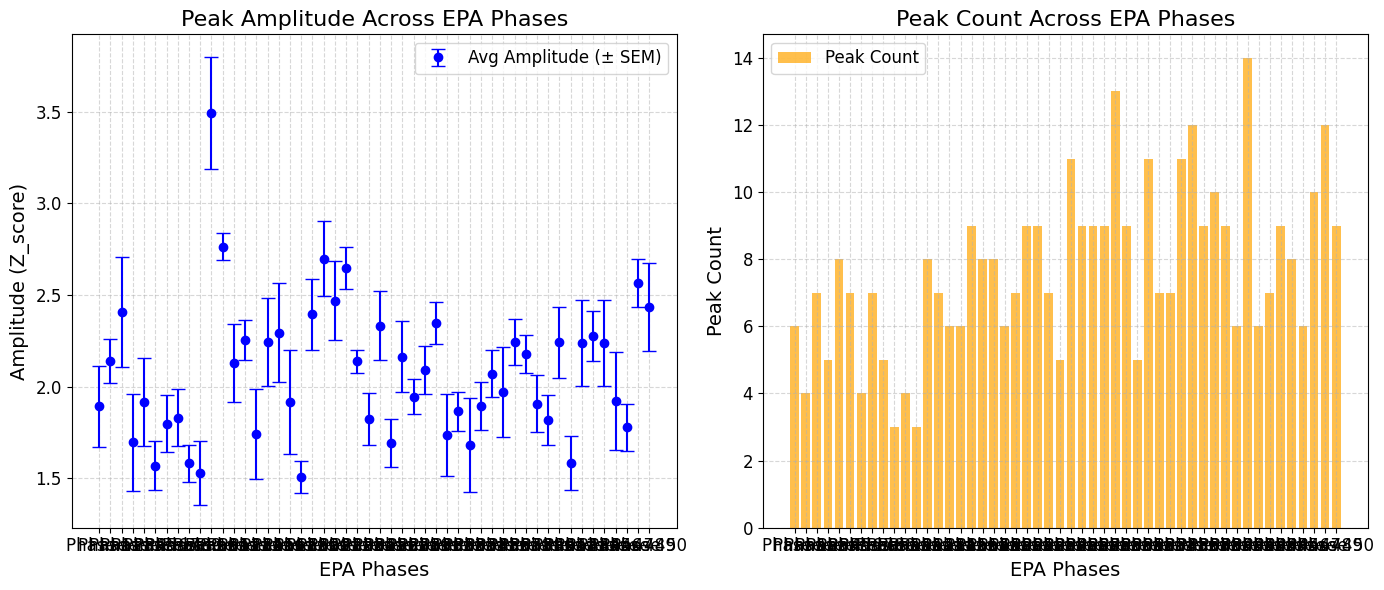

In [50]:
# Define font sizes
title_fontsize = 16
axis_label_fontsize = 14
legend_fontsize = 12
tick_fontsize = 12

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Average amplitude with SEM ---
axes[0].errorbar(
    range(len(peak_stats_df)),
    peak_stats_df['avg_amplitude'],
    yerr=peak_stats_df['sem_amplitude'],
    fmt='o', capsize=5, color='blue', label='Avg Amplitude (± SEM)'
)
axes[0].set_xlabel('EPA Phases', fontsize=axis_label_fontsize)
axes[0].set_ylabel('Amplitude (Z_score)', fontsize=axis_label_fontsize)
axes[0].set_title('Peak Amplitude Across EPA Phases', fontsize=title_fontsize)
axes[0].set_xticks(range(len(peak_stats_df)))
axes[0].set_xticklabels([f"Phase {i + 1}" for i in range(len(peak_stats_df))], fontsize=tick_fontsize)
axes[0].tick_params(axis='y', labelsize=tick_fontsize)
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(fontsize=legend_fontsize)

# --- Plot 2: Peak count ---
axes[1].bar(
    range(len(peak_stats_df)), peak_stats_df['peak_count'], color='orange', alpha=0.7, label='Peak Count'
)
axes[1].set_xlabel('EPA Phases', fontsize=axis_label_fontsize)
axes[1].set_ylabel('Peak Count', fontsize=axis_label_fontsize)
axes[1].set_title('Peak Count Across EPA Phases', fontsize=title_fontsize)
axes[1].set_xticks(range(len(peak_stats_df)))
axes[1].set_xticklabels([f"Phase {i + 1}" for i in range(len(peak_stats_df))], fontsize=tick_fontsize)
axes[1].tick_params(axis='y', labelsize=tick_fontsize)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend(fontsize=legend_fontsize)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


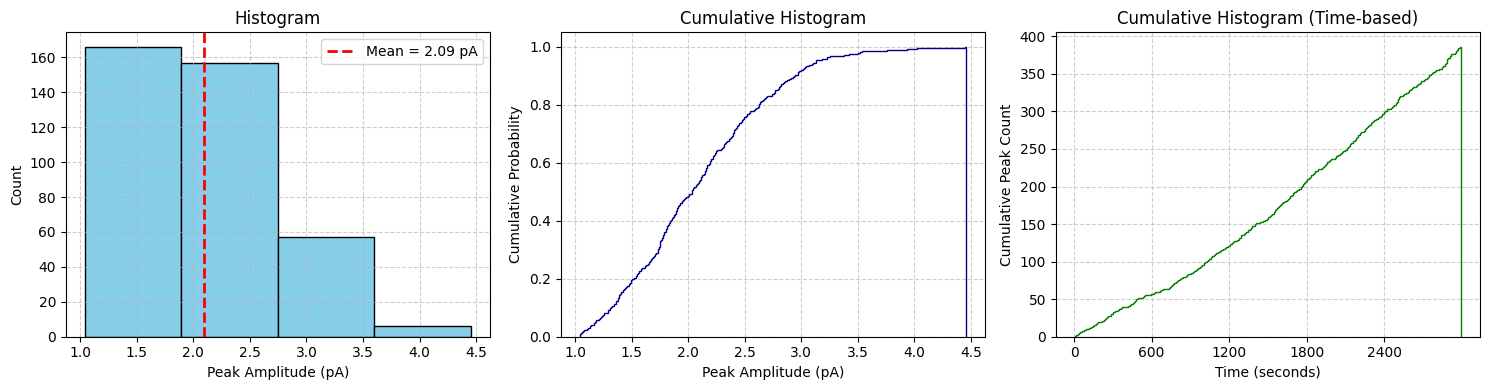

   events  duration  mean_frequency  mean_amplitude  std_amplitude
0     386    3000.0        0.128667        2.093736       0.622884


In [51]:
# Plot settings
time = np.arange(150000)  # Example time data (replace as needed)
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)  # Histogram plot
ax2 = fig.add_subplot(1, 3, 2)  # Cumulative histogram plot
ax3 = fig.add_subplot(1, 3, 3)  # Time-based cumulative histogram plot

# Histogram data (use your actual data)
hist_data = table['peak_amp']

# Bin size for amplitude histogram
bin_size_hist = 1  
num_bins = int(np.ceil((max(hist_data) - min(hist_data)) / bin_size_hist))

# --- Plot 1: Histogram ---
ax1.hist(hist_data, bins=num_bins, range=(min(hist_data), max(hist_data)), color='skyblue', edgecolor='black')
ax1.axvline(x=hist_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {hist_data.mean():.2f} pA')
ax1.set_title('Histogram')
ax1.set_ylabel("Count")
ax1.set_xlabel("Peak Amplitude (pA)")
ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.legend()

# --- Plot 2: Cumulative Histogram ---
ax2.hist(hist_data, bins=len(np.unique(hist_data)),  # Length of unique values
         range=(min(hist_data), max(hist_data)),
         histtype='step',
         cumulative=True,
         density=True,
         color='darkblue')
ax2.set_title('Cumulative Histogram')
ax2.set_ylabel("Cumulative Probability")
ax2.set_xlabel("Peak Amplitude (pA)")
ax2.grid(True, which='both', linestyle='--', alpha=0.6)

# --- Plot 3: Cumulative Histogram (Time-based) ---
# Convert peak indices to time (seconds)
time_data = table['peak_index'] / fs

ax3.hist(time_data, bins=len(np.unique(time_data)), histtype='step', cumulative=True, color='green')
ax3.set_title('Cumulative Histogram (Time-based)')
ax3.set_ylabel("Cumulative Peak Count")
ax3.set_xlabel("Time (seconds)")
ax3.grid(True, which='both', linestyle='--', alpha=0.6)

# Set x-axis ticks to intervals of 600 seconds
max_time = time_data.max()
ax3.set_xticks(np.arange(0, max_time + 1, 600))
               
# Adjust layout
fig.tight_layout()

# --- Summary statistics ---
events = len(table['event'])
time_s = len(time) / fs
mean_frequency = events / time_s
mean_amplitude = np.mean(table['peak_amp'])
std_amplitude = np.std(table['peak_amp'])

# Create a pandas DataFrame for summary statistics
summary_stats = pd.DataFrame({
    'events': [events],
    'duration': [time_s],
    'mean_frequency': [mean_frequency],
    'mean_amplitude': [mean_amplitude],
    'std_amplitude': [std_amplitude]
})

# Display the plot and summary statistics
plt.show()
print(summary_stats)


In [52]:
# Define bin size and number of bins (same as in peak count analysis)
#bin_size = 30000  # 10 minutes in samples
num_bins = (len(peaks_signal) // bin_size) + (1 if len(peaks_signal) % bin_size != 0 else 0)

# Initialize results dictionary
auc_stats = {
    "bin_start": [],
    "bin_end": [],
    "auc_avg": [],
    "auc_sd": [],
    "auc_sem": []
}

# Calculate AUC per bin
for i in range(num_bins):
    bin_start = i * bin_size
    bin_end = min((i + 1) * bin_size, len(peaks_signal))  # Ensure last bin doesn't exceed signal length

    # Filter events within the current bin
    events_in_bin = table[(table['peak_index'] >= bin_start) & (table['peak_index'] < bin_end)]

    # Get the AUC values (under the 'area' column)
    auc_values = events_in_bin['area']

    # Append bin details and statistics
    auc_stats["bin_start"].append(bin_start)
    auc_stats["bin_end"].append(bin_end)
    if len(auc_values) > 0:
        auc_stats["auc_avg"].append(np.mean(auc_values))
        auc_stats["auc_sd"].append(np.std(auc_values))
        auc_stats["auc_sem"].append(np.std(auc_values) / np.sqrt(len(auc_values)))
    else:
        # Handle empty bins
        auc_stats["auc_avg"].append(np.nan)
        auc_stats["auc_sd"].append(np.nan)
        auc_stats["auc_sem"].append(np.nan)

# Convert results to a DataFrame
auc_stats_df = pd.DataFrame(auc_stats)

# Display the results
print(auc_stats_df)

# Optional: Save to a CSV file
output_file_path = "AUC_summary_by_bins.csv"
auc_stats_df.to_csv(output_file_path, index=False)
print(f"AUC summary saved to: {output_file_path}")


    bin_start  bin_end       auc_avg        auc_sd      auc_sem
0           0     3000   3870.216667   2675.126529  1092.115832
1        3000     6000   4880.952500   2445.112063  1222.556032
2        6000     9000   3775.312857   3024.237559  1143.054355
3        9000    12000   2070.442000   2277.964384  1018.736643
4       12000    15000   3377.402500   2775.350404   981.234545
5       15000    18000   1808.925714   1495.981762   565.427958
6       18000    21000    899.475000    965.756501   482.878250
7       21000    24000   2360.634286   1340.331224   506.597585
8       24000    27000   1659.482000   1284.761172   574.562663
9       27000    30000   1524.003333   1476.079807   852.215074
10      30000    33000  20476.067500  19568.585343  9784.292672
11      33000    36000   6318.136667   1263.052851   729.223903
12      36000    39000   6242.115000  11374.160714  4021.373086
13      39000    42000   6073.008571   3998.546544  1511.308537
14      42000    45000   3805.395000   3

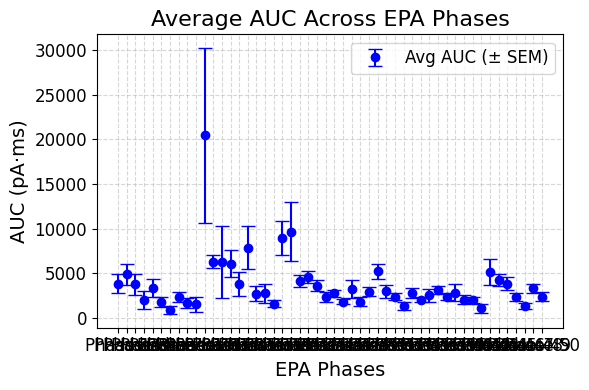

In [53]:
# Define font sizes
title_fontsize = 16
axis_label_fontsize = 14
legend_fontsize = 12
tick_fontsize = 12

# --- Plot Settings ---
fig, ax = plt.subplots(figsize=(6, 4))

# --- Plot: Average AUC with SEM ---
ax.errorbar(
    range(len(auc_stats_df)),
    auc_stats_df['auc_avg'],
    yerr=auc_stats_df['auc_sem'],
    fmt='o', capsize=5, color='blue', label='Avg AUC (± SEM)'
)

# Set axis labels, title, and grid
ax.set_xlabel('EPA Phases', fontsize=axis_label_fontsize)
ax.set_ylabel('AUC (pA·ms)', fontsize=axis_label_fontsize)
ax.set_title('Average AUC Across EPA Phases', fontsize=title_fontsize)
ax.set_xticks(range(len(auc_stats_df)))
ax.set_xticklabels([f"Phase {i + 1}" for i in range(len(auc_stats_df))], fontsize=tick_fontsize)
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.grid(True, linestyle='--', alpha=0.5)

# Add legend
ax.legend(fontsize=legend_fontsize)

# --- Adjust layout and display ---
plt.tight_layout()
plt.show()


In [54]:
# bouts = loaded_object.Grooming_annotations  # e.g. [(100,200), (500,600), …]
# # determine required vector length (you could also use len(Dlc_annotations) if that matches)
# max_frame = max(end for (_, end) in bouts)
# groom_30 = np.zeros(max_frame, dtype=int)
# for start, end in bouts:
#     groom_30[start:end] = 1

# behavior_fs_30 = 30.0
# recording_fs_50 = 50.0
# # time‐axes
# behavior_time = np.arange(len(groom_30)) / behavior_fs_30
# record_time = np.arange(len(filterdata)) / recording_fs_50

# from scipy.interpolate import interp1d
# f_groom = interp1d(
#     behavior_time,
#     groom_30,
#     kind="nearest",
#     bounds_error=False,
#     fill_value=(groom_30[0], groom_30[-1])
# )
# groom_50 = f_groom(record_time)

# # add a column to your peak table marking whether each peak fell during grooming
# table["in_groom"] = groom_50[table.peak_index].astype(bool)

# # quick check
# import matplotlib.pyplot as plt
# plt.figure(figsize=(8,3))
# plt.plot(filterdata, label="GCaMP z-score")
# plt.plot(groom_50 * np.max(filterdata), alpha=0.3, label="grooming (×scale)")
# # plt.xlim(0, 300000) #full trace 3000 = 1 min
# plt.xlim(0, 10000) #Zoomed in trace
# plt.legend()
# plt.show()


In [55]:
# # --- Event rates in vs. out of grooming ---
# # Computes total time in/out of grooming, counts peaks in each state, and prints event rates in Hz.

# # total time (s) spent in grooming vs. not
# total_groom_s     = np.sum(groom_50) / recording_fs_50
# total_non_groom_s = (len(groom_50) - np.sum(groom_50)) / recording_fs_50

# # counts of peaks
# n_groom = table.in_groom.sum()
# n_non   = len(table) - n_groom

# # rate = events per second
# rate_groom     = n_groom     / total_groom_s
# rate_non_groom = n_non       / total_non_groom_s

# print(f"Total time grooming:             {total_groom_s:.1f} sec\nNumber of events while grooming: {n_groom} events\nEvent frequency while grooming:  {rate_groom:.3f} Hz")
# print(f"Total time not grooming:         {total_non_groom_s:.1f} sec\nNumber of events while grooming: {n_non} events\nEvent frequency while grooming:  {rate_non_groom:.3f} Hz")


In [56]:
# # --- OPTION 3: Event‑triggered averages in vs. out of grooming ---
# # Extracts peri‑peak windows from your z‑scored trace, splits them by grooming state, averages, and plots the two waveforms aligned at the peak (time 0).

# # helper to extract an epoch around a given peak index
# def get_epoch(signal, idx, pre_samps, post_samps):
#     start = int(idx - pre_samps)
#     end   = int(idx + post_samps)
#     return signal[start:end]

# # how many samples before/after the peak
# pre_samps  = int(pretrigger_window)    # already in samples
# post_samps = int(posttrigger_window)   # already in samples

# # build epochs matrix [n_events × (pre+post) samples]
# all_epochs = np.stack([get_epoch(filterdata, idx, pre_samps, post_samps)
#                        for idx in table.peak_index])

# # separate grooming vs. non‑grooming
# epochs_groom    = all_epochs[table.in_groom.values]
# epochs_non      = all_epochs[~table.in_groom.values]

# # compute means
# mean_groom      = epochs_groom.mean(axis=0)
# mean_non_groom  = epochs_non.mean(axis=0)

# # time vector for plotting (in seconds)
# t_epoch = (np.arange(-pre_samps, post_samps) / recording_fs_50)

# # plot
# plt.figure(figsize=(6,4))
# plt.plot(t_epoch, mean_groom,     label="During Grooming")
# plt.plot(t_epoch, mean_non_groom, label="Outside Grooming")
# plt.axvline(0, color='k', linestyle='--', linewidth=1)
# plt.xlabel("Time from peak (s)")
# plt.ylabel("GCaMP z‑score")
# plt.title("Event‑Triggered Average")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [57]:
# # ─── Save events summary to Excel ─────────────────────────────────────────────

# # Create export DataFrame with exactly the columns you asked for:
# export_df = pd.DataFrame({
#     'event':         table.index,          # 0, 1, 2, … 
#     'peak_time_s':   table['peak_time_s'], # time in seconds
#     'peak_amp':      table['peak_amp'],    # amplitude
#     'area':          table['area']         # event area
# })

# # Build output filename in the same folder as your pickle:
# output_path = os.path.join(data_folder, f"{filename}_events_summary.xlsx")

# # Actually write the Excel file (requires openpyxl or xlsxwriter installed):
# export_df.to_excel(output_path, index=False)

# print(f"Saved {len(export_df)} events to:\n  {output_path}")


In [58]:

# ─── 1. assign bins ─────────────────────────────────────────────────────────────
table['bin'] = (table['peak_index'] // bin_size) + 1

# ─── 2a. event‐level DataFrame ─────────────────────────────────────────────────
events_df = table.loc[:, ['event', 'peak_time_s', 'peak_amp', 'area']].copy()

# ─── 2b. bin‐summary DataFrame ────────────────────────────────────────────────
summary_df = (
    table
    .groupby('bin')
    .agg(
        event_count   = ('event', 'count'),
        avg_peak_amp  = ('peak_amp', 'mean'),
        sd_peak_amp   = ('peak_amp', 'std'),
        total_area      = ('area', 'sum'),
    )
    .reset_index()
)

# ─── add peak_sd right after event_count ───────────────────────────────────────
summary_df['peak_sd'] = summary_df['sd_peak_amp']

# ─── now compute bin_start / bin_end ───────────────────────────────────────────
summary_df['bin_start'] = (summary_df['bin'] - 1) * bin_size
summary_df['bin_end']   = summary_df['bin']       * bin_size

# ─── reorder so peak_sd follows event_count ────────────────────────────────────
summary_df = summary_df[
    ['bin', 'bin_start', 'bin_end',
     'event_count',
     'avg_peak_amp', 'sd_peak_amp',
     'total_area']
]

# ─── 3. write to Excel with two sheets ─────────────────────────────────────────
output_path = os.path.join(
    data_folder,
    f"{filename}_event_summary.xlsx"   # now just "<filename>_event_summary.xlsx"
)
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    events_df.to_excel(writer, sheet_name='Events', index=False)
    summary_df.to_excel(writer, sheet_name='Bin_summary', index=False)

print(f"Saved {len(events_df)} events + {len(summary_df)} bins to:\n  {output_path}")


Saved 386 events + 50 bins to:
  Z:\UriMons\Fiber Photometry\GCaMP\Habenula\Processed_Data\Pickles\M564_eEPA_Habenula_event_summary.xlsx
